In [2]:
import xarray as xr
import matplotlib.dates as mdates
import numpy as np
import matplotlib
from matplotlib import rcParams
import datetime
import pandas as pd
import cftime
import pylab as plt
import netCDF4 as nc
from numpy import ma
import dask as dd

In [3]:
#stash codes
stash_ch4 = 'mass_fraction_of_methane_in_air'
stash_co = 'mass_fraction_of_carbon_monoxide_in_air'
stash_ch4_oh = 'm01s50i041'
#stash_oh = 'mass_fraction_of_hydroxyl_radical_in_air'
stash_oh = 'oh'
stash_o3 = 'mass_fraction_of_ozone_in_air'
stash_trop = 'trop_mask'
stash_mass = 'airmass_atm'
stash_temp = 'surface_temperature'

In [4]:
#define functions
def molec_cm3(conc_kg_kg, mass, vol, mr):
    molec_box = conc_kg_kg*mass/mr*1000*n_a #molecules per box
    molec_cm3 = molec_box/(vol*1e6) #molec per cm3
    return molec_cm3

In [5]:
# Altitude data to obtain volumes

data_alt = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/vol_n96.nc')
vol = data_alt.grid_cell_volume
vol = vol.data

In [6]:
#define variables
oh_mr = 17
n_a = 6.022e23

In [7]:
#Extract data

airmass_data_443 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bh443/u-bh443_301yrs_airmass_atm.nc',chunks={'time':24})
airmass_443 = airmass_data_443.variables[stash_mass][:]

oh_data_443 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bh443/u-bh443_301yrs_oh.nc',chunks={'time':24})
oh_443 = oh_data_443.variables[stash_oh][:]

trop_data = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bh443/u-bh443_301yrs_trop_mask.nc',chunks={'time':24})
trop_data['mask'] = xr.ones_like(trop_data.trop_mask)
trop_data['mask'] = trop_data.mask.where(trop_data.trop_mask>0.99999,other=0.)
trop_mask = trop_data.mask

time = oh_data_443.time[:]

In [8]:
#convert oh to molec cm-3
oh_molec_cm3 = molec_cm3(oh_443, airmass_443,vol, oh_mr)

In [9]:
#Apply troposhperic mask to oh data and take mean

airmass_trop = airmass_443*trop_mask
# oh_trop = ma.masked_where(trop_mask<0.9999999,oh_molec_cm3)
oh_trop_mean = dd.array.average(oh_molec_cm3, weights=airmass_trop, axis = (1,2,3))
oh_map_mean = dd.array.average(oh_molec_cm3, weights=airmass_trop, axis = (0,1))

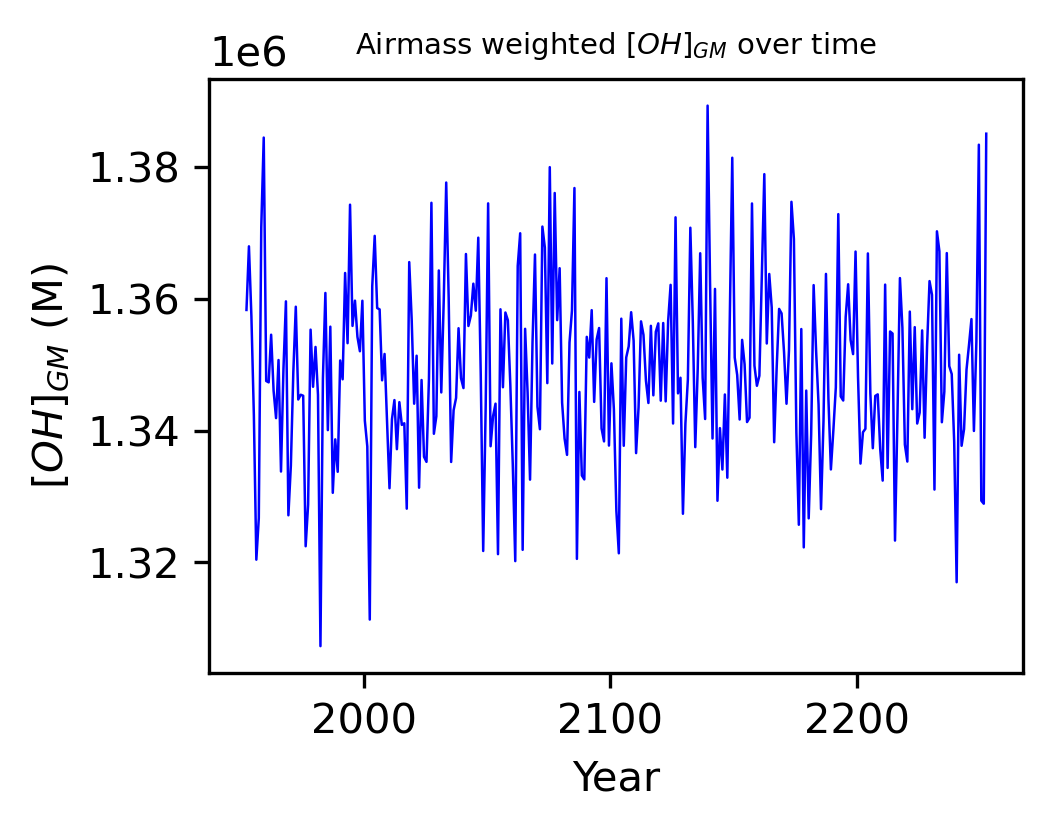

In [10]:
fig = plt.figure(figsize=(3.5,2.625), dpi=300)
ax = plt.axes()

ax.set_xlabel('Year')
ax.set_ylabel('$[OH]_{GM}$ (M)')
plt.title('Airmass weighted $[OH]_{GM}$ over time', fontsize = 7)

ax.plot(time, oh_trop_mean, c='blue', linewidth=0.6)

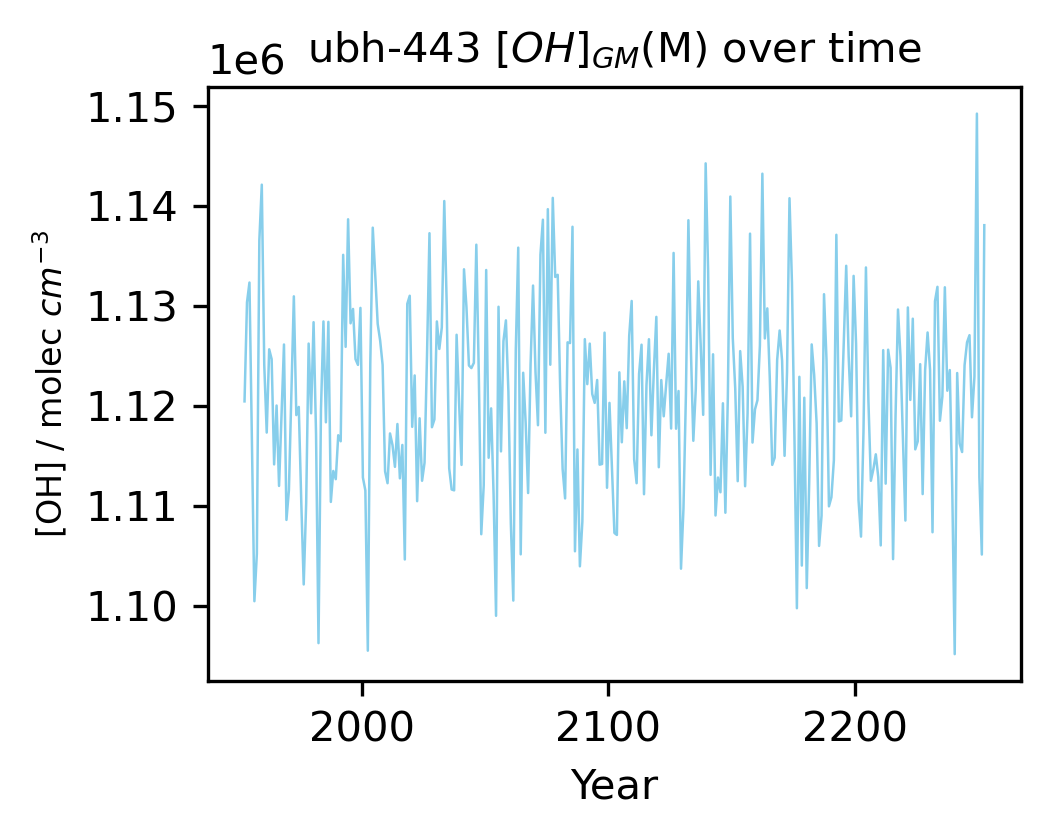

In [11]:
# Check values for whole atmosphere

oh_mean = dd.array.average(oh_molec_cm3, weights=airmass_443, axis = (1,2,3))

fig = plt.figure(figsize=(3.5,2.625), dpi=300)
ax = plt.axes()

plt.xlabel("Year")
ax.set_ylabel("[OH] / molec $cm^{-3}$", fontsize=8)
plt.title("ubh-443 $[OH]_{GM}$(M) over time", fontsize=10)

line0, = ax.plot(time, oh_mean, c='skyblue', linewidth=0.6)

In [13]:
# Export some total values

oh_443 = xr.DataArray(data=oh_mean,
                           name='oh_whole_atmos_u-bh443',
                           dims=['time'], 
                           attrs=dict(
                            standard_name = "molec_conc_oh",
                            units = "molec cm-3",
                            dom_stash_source = "oh_molec_cm3",
                            cell_methods = "time: mean (interval: 1 hour)"  
                           ),
                           coords=dict(
                               time = (['time'],time.data)
                           )
                          )


oh_443.to_netcdf('u-bh443_total_atmos.nc')

In [ ]:
## Map Plotting imports

from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib import cm
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [ ]:
lon = oh_data_443.longitude
lat = oh_data_443.latitude

In [ ]:
# Plot map of OH data for bh443

fig = plt.figure(figsize=(3.5,2.625), dpi=300)

ax = plt.axes(projection=ccrs.Robinson(central_longitude=0, globe=None))
ax.set_global()
ax.coastlines(linewidth=0.5)

oh_conc_cyclic, lon_plot = add_cyclic_point(oh_map_mean,coord=lon)   


plt.pcolormesh(lon_plot,lat,oh_conc_cyclic, cmap='RdPu',transform=ccrs.PlateCarree(central_longitude=0), vmin=0, vmax=5e6)

plt.colorbar(label = '$[OH]_{GM}$ (M) / molec $cm^{-3}$' ,orientation='horizontal',pad=0.05, extend='both')

In [ ]:
## Export plotting values for comparison plots

oh_443 = xr.DataArray(data=oh_map_mean,
                           name='oh_map_u-bh443',
                           dims=["latitude","longitude"], 
                           attrs=dict(
                            standard_name = "oh_concentration",
                            units = "molec cm-3",
                            um_stash_source = "oh_molec_cm3",
                            cell_methods = "time: mean (interval: 1 hour)",
                            grid_mapping = "latitude_longitude"  
                           ),
                           coords=dict(
                               latitude = (["latitude"], lat.data),
                               longitude = (["longitude"], lon.data)
                           )
                          )


oh_443.to_netcdf('Data/u-bh443_oh_map.nc')

oh_443 = xr.DataArray(data=oh_trop_mean,
                           name='oh_map_u-bh443',
                           dims=["time"], 
                           attrs=dict(
                            standard_name = "oh_concentration",
                            units = "molec cm-3",
                            um_stash_source = "oh_molec_cm3",
                            cell_methods = "time: mean (interval: 1 hour)",
                            grid_mapping = "latitude_longitude"  
                           ),
                           coords=dict(
                               time=time
                           )
                          )


oh_443.to_netcdf('Data/u-bh443_oh_gm.nc')